<a href="https://colab.research.google.com/github/Hannitomado/KC--Deep-Learning-Computer-Vision/blob/main/Practica_Modulo_Deep_Learning_%26_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modulo Deep Learning & Computer Vision

## Practica Final

#### Alumno: Hannibal Tomasson Izquierdo


### Objetivo

Resolver un problema del mundo real empleando las tecnicas vistas durante las sesiones del modulo. La tarea principal es predecir la condicion medica sufrida por una cohorte de pacientes a partir de las diferentes fuentes de informacion disponibles, que son imagenes y datos tabulares.

### Dataset

Para la practica utilizaremos el dataset HAM10000, que es un conjunto de datos diseñado para el entrenamiento y evaluacion de modelos de aprendizaje automatico en el diagnostico de enefermedades de la piel a partir de imagenes dermatoscopicas. El dataset contiene 10.015 imagenes de lesiones cutaneas clasificadas en siete categorias distintas, abarcando enfermedades benignas y malignas, y con una variabilidad y representatividad elevadas.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd

data_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/HAM10000_metadata.csv"

df = pd.read_csv(data_path)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Ahora que ya tenemos cargado el dataset, y hemos comprobado que contiene la informacion que esperabamos, vamos a explorar un poco mas los datos, y en base a lo que encontremos decidir cual sera nuestro siguiente paso.

Un dato interesante que hemos recordar a la hora de hacer la division de datos es que cada lesion_id parece estar conectada a dos imagenes distintas. Esto es importantante por que a la hora de preprocesar los datos para evitar que imagenes del mismo paciente acaban en particiones distintas.

In [2]:
# Obtenemos informacion basica sobre el dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [3]:
# Informacion estadistica sobre las columnas numericas
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


La unica columna numerica que tenemos es la edad de los participantes, y como observamos la media esta sobre los 50 años de edad.

In [4]:
# Buscamos missing values
print("Numero de missing values por columna:")
print(df.isnull().sum())

Numero de missing values por columna:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64


Casualmente solo la columna de edad tiene missing values. Esto es en parte una buena noticia, por lo que no deberia sernos demasiado dificil solucionarlo. Una manera sencilla de hacerlo es imputar los datos faltantes con la mediana. Dado que en nuestro caso la mediana (50.00) y la media (51.86) tienen un valor tan similar, esta deberia ser una opcion segura.

In [5]:
median_age = df['age'].median()
df['age'] = df['age'].fillna(median_age)

In [6]:
# Comprobamos que la imputacion ha funcionado
print("Numero de missing values por columna:")
print(df.isnull().sum())

Numero de missing values por columna:
lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64


A continuacion vamos a seguir explorando el resto de datos tabulares que constituyen nuestro dataset.


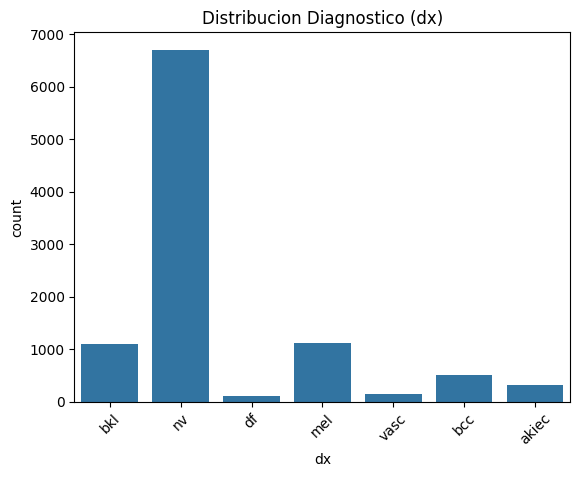

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Contamos el total de cada uno de los diagnosticos
df['dx'].value_counts()

# Visualizamos la distribucion
sns.countplot(x='dx', data=df)
plt.xticks(rotation=45)
plt.title("Distribucion Diagnostico (dx)")
plt.show()

In [8]:
df['dx'].value_counts()

,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


En esta grafica podemos ver que la mayor parte de los diagnosticos recaen en la categoria nv, que se refiere a la enfermedad 'Nevus Melanocitico'. En segundo y tercer lugar, con una diferencia no demasiado grande entre ellos pero muy por debajo de la cantidad de 'nv', tenemos 'Melanoma' (mel) y 'Lesiones benignas de queratosis' (bkl). El resto de categorias tienen un numero muy reducido de valores.

Esto nos proporciona informacion muy valiosa que debemos tener en cuenta. Primero, para evitar que algunas categorias desaparezcan por completo cuando dividamos los datos, tendremos que hacer una division de datos estratificada (Stratified Splitting), manteniendo asi las proporciones de cada categoria. Segundo, durante la fase de modelado deberiamos de modificar los pesos de cada categoria. Asi, a las categorias menos representadas les asignaremos pesos mayores, para que el modelo sufra una mayor penalizacion si las clasifica mal.

Por el momento, sigamos explorando los datos.

In [9]:
print("Sexo:", df['sex'].unique())
print("Localizacion:", df['localization'].unique())
print("Tipo de Diagnostico:", df['dx_type'].unique())

Sexo: ['male' 'female' 'unknown']
Localizacion: ['scalp' 'ear' 'face' 'back' 'trunk' 'chest' 'upper extremity' 'abdomen'
 'unknown' 'lower extremity' 'genital' 'neck' 'hand' 'foot' 'acral']
Tipo de Diagnostico: ['histo' 'consensus' 'confocal' 'follow_up']


Tenemos aqui otras tres columnas categoricas. 'sex' contiene 3 tipos de valores distintos, que proporcionan informacion sobre el sexo del paciente. 'localization' tiene 15 valores distintos, que indican donde se encuentra la patologia. Y 'dx_type', con 4 valores, nos da informacion sobre como se ha llegado al diagnostico en concreto.

Las dos primeras no tienen demasiada cardinalidad, asi que podriamos preprocesarlas usando one-hot encoding. La importancia del tipo de diagnostico parece un poco mas difusa, aunque es sin duda informacion util para el personal medico. Al no estar claro de que manera va a ayudar a nuestro modelo, no la vamos a incluir en nuestro entrenamiento.

In [10]:
# Eliminamos dx_type
df.drop(columns=['dx_type'], inplace=True)

In [11]:
# Aplicamos one-hot encoding a sex y localization
df = pd.get_dummies(df, columns=['sex', 'localization'], prefix=['sex', 'loc'])

In [12]:
# Comprobamos que los cambios han funcionado
print(df.columns)
print(df.head())

Index(['lesion_id', 'image_id', 'dx', 'age', 'sex_female', 'sex_male',
       'sex_unknown', 'loc_abdomen', 'loc_acral', 'loc_back', 'loc_chest',
       'loc_ear', 'loc_face', 'loc_foot', 'loc_genital', 'loc_hand',
       'loc_lower extremity', 'loc_neck', 'loc_scalp', 'loc_trunk',
       'loc_unknown', 'loc_upper extremity'],
      dtype='object')
     lesion_id      image_id   dx   age  sex_female  sex_male  sex_unknown  \
0  HAM_0000118  ISIC_0027419  bkl  80.0       False      True        False   
1  HAM_0000118  ISIC_0025030  bkl  80.0       False      True        False   
2  HAM_0002730  ISIC_0026769  bkl  80.0       False      True        False   
3  HAM_0002730  ISIC_0025661  bkl  80.0       False      True        False   
4  HAM_0001466  ISIC_0031633  bkl  75.0       False      True        False   

   loc_abdomen  loc_acral  loc_back  ...  loc_face  loc_foot  loc_genital  \
0        False      False     False  ...     False     False        False   
1        False      False 

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['age'] = scaler.fit_transform(df[['age']])

Ahora que ya hemos explorado de manera satisfactoria nuestras variables, vamos a terminar con la fase de preprocesamiento. Para ello, primero vamos a asegurarnos de que el hecho de que haya 2 imagenes por lesion no cree un problema a la hora de dividir los datos.

Vamos a hacer un DataFrame temporal al que poder referir posteriormente cuando hagamos la division del dataset, y que nos ayude a asignar correctamente cada dato a uno de los grupos. El riesgo que podemos correr de no hacer esto, es que si alguna imagen apareciese en los sets de entrenamiento y test, el modelo aprenda patrones que le hagan generalizar en situaciones en las que no deberia. Esto podria darnos una falsa impresion de que el modelo tiene un buen rendimiento, cuando en realidad es overfitting.

In [14]:
lesion_df = df.groupby('lesion_id').first().reset_index()

print(lesion_df['dx'].value_counts())

dx
nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
Name: count, dtype: int64


Ahora, vamos a dividir los datos en sets de entrenamiento, validacion, y test. Como hemos mencionado antes, vamos a hacer una division estratificada para asegurar que mantenemos las proporciones de las distintas categorias.

In [15]:
from sklearn.model_selection import train_test_split

# Primera division: Train vs Temp (Validation + Test)
train_lesions, temp_lesions = train_test_split(lesion_df, test_size=0.3, random_state=42, stratify=lesion_df['dx'])

# Segunda division: Validation vs Test
val_lesions, test_lesions = train_test_split(temp_lesions, test_size=0.5, random_state=42, stratify=temp_lesions['dx'])

In [16]:
train_df = df[df['lesion_id'].isin(train_lesions['lesion_id'])]
val_df = df[df['lesion_id'].isin(val_lesions['lesion_id'])]
test_df = df[df['lesion_id'].isin(test_lesions['lesion_id'])]

In [17]:
# Comprobamos que los datos se han distribuido correctamente

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("Train dx distribution:")
print(train_df['dx'].value_counts())

print("Validation dx distribution:")
print(val_df['dx'].value_counts())

print("Test dx distribution:")
print(test_df['dx'].value_counts())

Train size: 6981
Validation size: 1532
Test size: 1502
Train dx distribution:
dx
nv       4683
mel       773
bkl       772
bcc       361
akiec     222
vasc       99
df         71
Name: count, dtype: int64
Validation dx distribution:
dx
nv       1018
mel       173
bkl       160
bcc        82
akiec      53
df         24
vasc       22
Name: count, dtype: int64
Test dx distribution:
dx
nv       1004
mel       167
bkl       167
bcc        71
akiec      52
vasc       21
df         20
Name: count, dtype: int64


Perfecto, parece ser que las proporciones se han mantenido en los tres sets que hemos creado. Nos quedan un par de pasos para terminar con el preprocesamiento, y comenzar con el entrenamiento de nuestros modelos.

Los valores de nuestra variable objetivo 'dx' aun son strings, asi que debemos convertirlos en valores numericos. Esto se puede hacer de manera muy sencilla con Scikitlearn 'LabelEncoder'

In [18]:
from sklearn.preprocessing import LabelEncoder

# Aplicamos el label encoder a todo el dataset
le = LabelEncoder()
le.fit(df['dx'])

# Transformamos las etiquetas de todos los sets
train_df.loc[:, 'label'] = le.transform(train_df['dx'])
val_df.loc[:, 'label'] = le.transform(val_df['dx'])
test_df.loc[:, 'label'] = le.transform(test_df['dx'])

# Guardamos un mapa de las etiquetas
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_map)

Label mapping: {'akiec': np.int64(0), 'bcc': np.int64(1), 'bkl': np.int64(2), 'df': np.int64(3), 'mel': np.int64(4), 'nv': np.int64(5), 'vasc': np.int64(6)}


<ipython-input-18-f0d84c575e29>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'label'] = le.transform(train_df['dx'])
<ipython-input-18-f0d84c575e29>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.loc[:, 'label'] = le.transform(val_df['dx'])
<ipython-input-18-f0d84c575e29>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

# Hito 1

En esta parte de la practica, vamos a crear, y entrenar un modelo de red neuronal, basado unicamente en los datos tabulares del dataset.Para empezar, vamos a seleccionar las columnas que vamos usar en nuestro modelo tabular, y definir los conjuntos.

In [19]:
# Seleccionamos las columnas a usar en el modelo tabular
feature_cols = [col for col in train_df.columns if col not in ['image_id', 'lesion_id', 'dx', 'label']]

# Creamos los conjuntos de train, validation y test
X_train = train_df[feature_cols].values
y_train = train_df['label'].values

X_val = val_df[feature_cols].values
y_val = val_df['label'].values

X_test = test_df[feature_cols].values
y_test = test_df['label'].values

In [20]:
X_train = train_df[feature_cols].astype('float32').values
X_val = val_df[feature_cols].astype('float32').values
X_test = test_df[feature_cols].astype('float32').values

Ahora vamos a proceder a crear la red neuronal, que va a ser del tipo MLP (Multilayer Perceptron). Como una precaucion, y para evitar tener que entrenar el modelo multiples veces, vamos a introducir codigo para guardar el modelo una vez entrenado, asi como el historial de resultados producido.

In [21]:
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
import json

In [22]:
# Numero de clases del problema
n_clases = len(label_map)

# Convertimos las etiquetas a one-hot
y_train_cat = to_categorical(y_train, num_classes=n_clases)
y_val_cat = to_categorical(y_val, num_classes=n_clases)
y_test_cat = to_categorical(y_test, num_classes=n_clases)

# Ruta para guardar y cargar modelo e historial
ruta_modelo_tabular = '/content/drive/MyDrive/Colab Notebooks/Dataset/modelo_tabular.keras'
ruta_historial_tabular = '/content/drive/MyDrive/Colab Notebooks/Dataset/historial_modelo_tabular.json'

# Flag para comprobar si entrenar o cargar el modelo
entrenar_modelo = True

if entrenar_modelo:
  # Definimos la arquitectura del modelo
  modelo = Sequential([
      Input(shape=(X_train.shape[1],)),
      Dense(128, activation='relu'),
      Dropout(0.5),
      Dense(64, activation='relu'),
      Dropout(0.5),
      Dense(n_clases, activation='softmax')
  ])

  modelo.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

  # Early stopping para evitar overfitting
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  # Entrenamiento del modelo
  historial = modelo.fit(
      X_train, y_train_cat,
      validation_data=(X_val, y_val_cat),
      epochs=100,
      batch_size=32,
      callbacks=[early_stopping]
  )

  # Guardamos el modelo
  modelo.save(ruta_modelo_tabular)
  print("Modelo Tabular guardado en:", ruta_modelo_tabular)

  # Guardamos el historial
  with open(ruta_historial_tabular, 'w') as f:
    json.dump(historial.history, f)
  print("Historial Modelo Tabular guardado en:", ruta_historial_tabular)

else:
  # Cargamos el modelo
  modelo = load_model(ruta_modelo_tabular)
  print("Modelo cargado desde:", ruta_modelo_tabular)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5917 - loss: 1.3750 - val_accuracy: 0.6873 - val_loss: 1.0409
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6922 - loss: 1.0340 - val_accuracy: 0.6873 - val_loss: 0.9842
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6953 - loss: 0.9858 - val_accuracy: 0.6906 - val_loss: 0.9782
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7031 - loss: 0.9594 - val_accuracy: 0.6945 - val_loss: 0.9647
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7003 - loss: 0.9468 - val_accuracy: 0.6939 - val_loss: 0.9605
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6973 - loss: 0.9373 - val_accuracy: 0.6919 - val_loss: 0.9588
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6941 - loss: 0.9447 - val_accuracy: 0.6932 - val_loss: 0.9589
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7045 - loss: 0.9393 - val_acc

El modelo parece haberse entrenado satisfactoriamente y aunque le habiamos indicado que hiciese 100 epochs de maximo, al incluir EarlyStopping ha parado cuando ha detectado que el rendimiento no estaba mejorando. La precision del modelo se ha estabilizado en torno al 70% en el conjunto de entrenamiento, y una cifra muy similar de entre el 69% y 70% en el conjunto de validacion.

Parece claro es que la arquitectura que hemos creado funciona, y que el modelo ha aprendido a partir de los datos de nuestro dataset. Para ilustrar mejor estos resultados, vamos a visualizar una grafica que muestre el aprendizaje del modelo.

Historial Modelo Tabular cargado


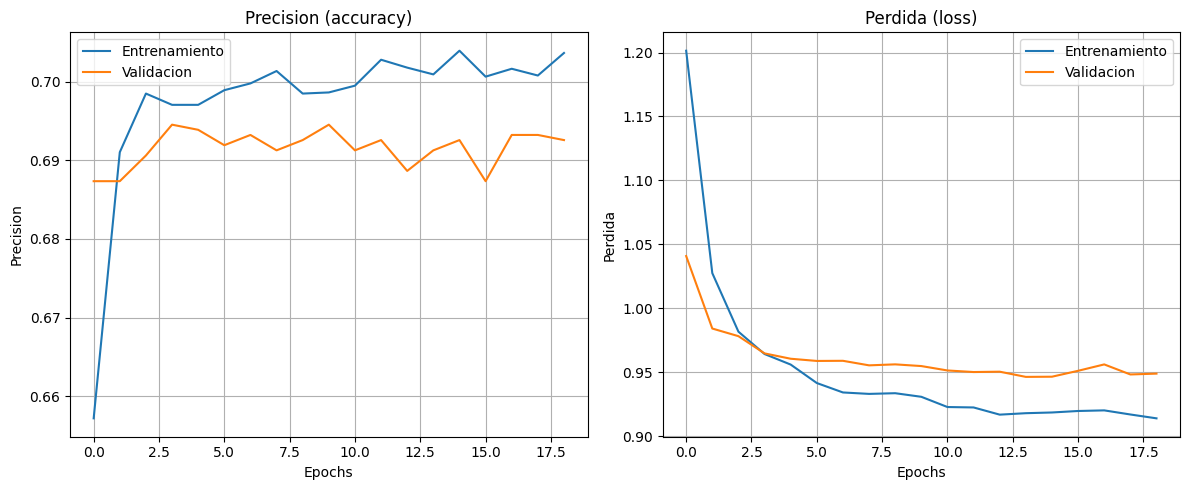

In [23]:
# Ruta al historial guardado
ruta_historial_tabular = '/content/drive/MyDrive/Colab Notebooks/Dataset/historial_modelo_tabular.json'

# Cargamos el historial
with open(ruta_historial_tabular, 'r') as f:
  historial_modelo_tabular = json.load(f)

print("Historial Modelo Tabular cargado")

# Curvas de precision (accuracy)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historial_modelo_tabular['accuracy'], label='Entrenamiento')
plt.plot(historial_modelo_tabular['val_accuracy'], label='Validacion')
plt.title('Precision (accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Curvas de perdida (loss)
plt.subplot(1, 2, 2)
plt.plot(historial_modelo_tabular['loss'], label='Entrenamiento')
plt.plot(historial_modelo_tabular['val_loss'], label='Validacion')
plt.title('Perdida (loss)')
plt.xlabel('Epochs')
plt.ylabel('Perdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Las curvas de precision nos muestran que como ya veiamos en los resultados, la precision asciende de manera rapida y se estabiliza en torno al 70%. Hay unas discrepancias entre entrenamiento y validacion que pueden indicar un pequeño overfitting. Pero las diferencias son muy pequeñas.

En cuanto a las de perdida, nos cuentan una historia muy similar, con una bajada rapida y una estabilizacion posterior.

Ahora para seguir comprobando como funciona nuestro modelo, vamos a generar una matriz de confusion, lo que nos indicara cuantas veces el modelo ha acertado o se ha equivocado por cada clase.


In [25]:
import numpy as np

y_pred_probs = modelo.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


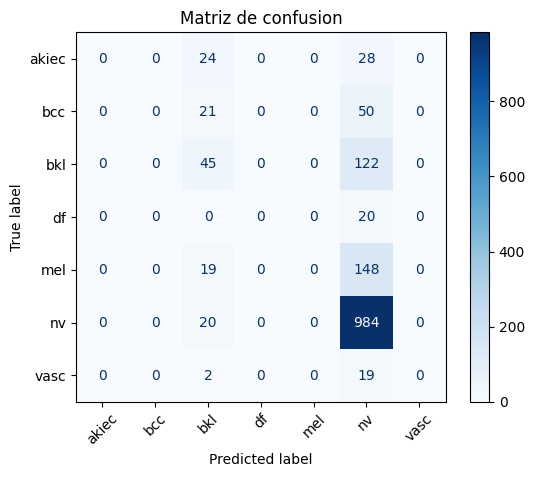

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Visualizamos la matriz de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de confusion")
plt.show()

In [27]:
from sklearn.metrics import classification_report

# Informe detallado
print("Informe de clasificacion:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Informe de clasificacion:
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        52
         bcc       0.00      0.00      0.00        71
         bkl       0.34      0.27      0.30       167
          df       0.00      0.00      0.00        20
         mel       0.00      0.00      0.00       167
          nv       0.72      0.98      0.83      1004
        vasc       0.00      0.00      0.00        21

    accuracy                           0.69      1502
   macro avg       0.15      0.18      0.16      1502
weighted avg       0.52      0.69      0.59      1502



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Al parecer el valor de precision que habiamos obtenido nos habia hecho cantar victoria demasiado rapido. Observando el funcionamiento real del modelo podemos ver que realmente no es que sea muy bueno prediciendo clases, si no que es muy bueno prediciendo aquella clase que esta sobrerepresentada en el dataset.

Seria un poco insatisfactorio dejarlo asi, por lo que vamos a hacer lo que anunciamos cuando advertimos que estaban seriamente desbalanceados.
Vamos a introducir una modificacion a los pesos de cada clase para que su importancia no se base solo en el numero de datos, y vamos a entrenar el modelo de nuevo.

In [28]:
from sklearn.utils import class_weight

# Rutas para el modelo tabular actualizado

ruta_modelo_tabular = '/content/drive/MyDrive/Colab Notebooks/Dataset/modelo_tabular_pesos.keras'
ruta_historial_tabular = '/content/drive/MyDrive/Colab Notebooks/Dataset/historial_modelo_tabular_pesos.json'

# Calculamos los pesos balanceados
pesos_clase = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
pesos_clase_dict = dict(enumerate(pesos_clase))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

modelo.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=pesos_clase_dict
)

# Guardamos modelo e historial
modelo.save(ruta_modelo_tabular)
print("Modelo Tabular guardado en:", ruta_modelo_tabular)

with open(ruta_historial_tabular, 'w') as f:
    json.dump(historial.history, f)
print("Historial Modelo Tabular guardado en:", ruta_historial_tabular)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6174 - loss: 1.9219 - val_accuracy: 0.3022 - val_loss: 1.4880
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3553 - loss: 1.5983 - val_accuracy: 0.1952 - val_loss: 1.6011
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2878 - loss: 1.5902 - val_accuracy: 0.3949 - val_loss: 1.5185
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3645 - loss: 1.6554 - val_accuracy: 0.3597 - val_loss: 1.5451
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3140 - loss: 1.5778 - val_accuracy: 0.3792 - val_loss: 1.5533
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3354 - loss: 1.6432 - val_accuracy: 0.3897 - val_loss: 1.4782
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3453 - loss: 1.5944 - val_accuracy: 0.3597 - val_loss: 1.5454
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3244 - loss: 1.5900 - val_acc

In [29]:
import numpy as np

# Predicciones
y_pred_probs = modelo.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


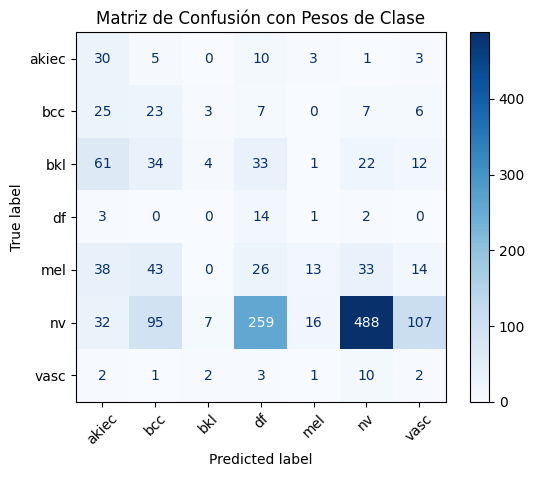

In [30]:
# Visualizamos la matriz de confusion actualizada
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión con Pesos de Clase")
plt.show()

In [31]:
from sklearn.metrics import classification_report

print("Informe de clasificación con class_weight:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Informe de clasificación con class_weight:
              precision    recall  f1-score   support

       akiec       0.16      0.58      0.25        52
         bcc       0.11      0.32      0.17        71
         bkl       0.25      0.02      0.04       167
          df       0.04      0.70      0.08        20
         mel       0.37      0.08      0.13       167
          nv       0.87      0.49      0.62      1004
        vasc       0.01      0.10      0.02        21

    accuracy                           0.38      1502
   macro avg       0.26      0.33      0.19      1502
weighted avg       0.66      0.38      0.45      1502



Como podemos comprobar, y aunque parecia que la precision general del modelo habia bajado drasticamente, lo que podemos comprobar es todo lo contrario: el modelo ha mejorado su capacidad de prediccion.

Ahora obtiene mas aciertos en las categorias que anteriormente estaban subrepresentadas. Y si bien es cierto que ha bajado bastante en su poder de prediccion con respecto a 'nv', ha mejorado un poco en todas las demas.

# Hito 2

En este segundo hito, vamos a utilizar una red convolucional para que nuestro modelo sea capaz de aprender a partir de imagenes. En primera instancia vamos a utilizar el modelo para obtener embeddings al final de la extraccion de caracteristicas, y vamos a entrenar tan solo un clasificador sobre estos embeddings. Dependiendo de los resultados que esto produzca, decidiremos de que manera podemos mejorar el modelo.

Para empezar a trabajar con las imagenes del dataset, primero tenemos que extraerlas de los archivos donde las hemos descargado.

In [32]:
import zipfile

# Ruta a las imagenes de HAM10000
zip_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/HAM10000_images_part_1.zip'
zip_path2 = '/content/drive/MyDrive/Colab Notebooks/Dataset/HAM10000_images_part_2.zip'

extract_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/HAM10000_images'

# Comprobamos si las imagenes ya se han extraido
images_exist = [
    f for f in os.listdir(extract_path) if f.endswith('.jpg')
] if os.path.exists(extract_path) else []

if len(images_exist) > 0:
    print("Las imagenes ya han sido extraidas.")
else:
# Descomprimimos las imagenes
    print("Extrayendo imagenes...")
    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
    with zipfile.ZipFile(zip_path2, 'r') as zip_ref:
      zip_ref.extractall(extract_path)
    print("Imagenes extraidas en:", extract_path)

Las imagenes ya han sido extraidas.


Ahora vamos a asociar cada imagen con su identificador

In [33]:
# Anadimos columna con ruta a la imagen
for df in [train_df, val_df, test_df]:
  df.loc[:, 'filepath'] = df['image_id'].apply(lambda x: f"{extract_path}/{x}.jpg")

<ipython-input-33-425fae8ad196>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'filepath'] = df['image_id'].apply(lambda x: f"{extract_path}/{x}.jpg")
<ipython-input-33-425fae8ad196>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'filepath'] = df['image_id'].apply(lambda x: f"{extract_path}/{x}.jpg")
<ipython-input-33-425fae8ad196>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [34]:
# Comprobamos que las imagenes se han extraido y asignado correctamente
for df_name, df in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    exist = df['filepath'].apply(os.path.exists)
    print(f"{df_name}: {exist.sum()} de {len(df)} imagenes encontradas.")

train: 6981 de 6981 imagenes encontradas.
val: 1532 de 1532 imagenes encontradas.
test: 1502 de 1502 imagenes encontradas.


Como podemos comprobar, las imagenes de HAM10000 se han cargado, extraido y asignado correctamente. Nuestro siguiente paso sera preprocesarlas para que tenga el formato ideal para nuestro modelo.

Si lo dejasemos aqui, aun tendriamos otro problema a la hora de intentar entrenar el modelo, y es que el modelo va a intentar leer las imagenes directamente desde Google Drive. Esta no es la manera mas optima de proceder, asi que vamos a copiar las imagenes al almacenamiento local de Colab, para que asi pueda acceder a ellas directamente.

In [35]:
import shutil

# Ruta original en Google Drive
original_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/HAM10000_images'

# Ruta de destino en Colab
destination_path = '/content/HAM10000_images'

# Comprobamos si las imagenes estan ya en la carpeta de destino
images_local_content = [f for f in os.listdir(destination_path) if f.endswith('.jpg')
] if os.path.exists(destination_path) else []

if len(images_local_content) > 0:
    print("Las imagenes ya han sido copiadas al entorno local de Colab.")
else:
    print("Copiando imagenes al entorno local de Colab...")
    shutil.copytree(original_path, destination_path)
    print("Imagenes copiadas al entorno local de Colab.")

Las imagenes ya han sido copiadas al entorno local de Colab.


Solucionado ese problema, pasamos al siguiente. Al intentar entrenar el modelo, hemos recibido un mensaje de error indicandonos que algun archivo no era valido o una imagen resultaba ilegible. Necesitamos pues encontrar donde esta esa imagen, solucionar el problema para poder seguir con el entrenamiento del modelo.

In [36]:
for nombre, df in zip(['Train', 'Val', 'Test'], [train_df, val_df, test_df]):
    rutas = df['filepath']
    errores = rutas[~rutas.apply(lambda x: os.path.isfile(x) and x.lower().endswith('.jpg'))]
    print(f"{nombre}: {len(errores)} archivos inválidos encontrados")

    # Mostramos algunos si hay
    if not errores.empty:
        print(errores.head())


Train: 0 archivos inválidos encontrados
Val: 0 archivos inválidos encontrados
Test: 0 archivos inválidos encontrados


Parece ser que todos los archivos son validos, asi que vamos a explorar las imagenes.

In [37]:
from PIL import Image

# Creamos una funcion que filtra las imagenes legibles
def es_legible(path):
    try:
        img = Image.open(path)
        img.verify()
        return True
    except:
        return False

for nombre, df in zip(['Train', 'Val', 'Test'], [train_df, val_df, test_df]):
    ilegibles = df[~df['filepath'].apply(es_legible)]
    print(f"{nombre}: {len(ilegibles)} imágenes ilegibles encontradas")
    if not ilegibles.empty:
        print(ilegibles[['image_id', 'filepath']].head())


Train: 1 imágenes ilegibles encontradas
          image_id                                           filepath
3823  ISIC_0028058  /content/drive/MyDrive/Colab Notebooks/Dataset...
Val: 1 imágenes ilegibles encontradas
          image_id                                           filepath
2130  ISIC_0024313  /content/drive/MyDrive/Colab Notebooks/Dataset...
Test: 0 imágenes ilegibles encontradas


En efecto, habia imagenes ilegibles, y dadas nuestras capacidades actuales, no seria realista intentar descubrir la razon por la que lo son. Asi, lo mas pragmatico sera no contar con ellas entre nuestros datos de entrenamiento, y aplicar nuestra funcion filtro para recrear ese conjunto.

In [38]:
train_df = train_df[train_df['filepath'].apply(es_legible)]
val_df = val_df[val_df['filepath'].apply(es_legible)]
test_df = test_df[test_df['filepath'].apply(es_legible)]

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
# Creamos el generador con aumentos para el conjunto de entrenamiento
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Reescalamos para validacion y test
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

Ya hemos aplicado correctamente ImageDataGenerator a nuestro dataset para que el modelo pueda utilizar correctamente su informacion en el entrenamiento.

Ahora vamos a utilizar el modelo preentrenado EfficientNetB0. Despues de buscar entre la literatura, y considerar ResNet50 y MobileNetV2, nos hemos decantado por EfficientNetB0 por que en general parece demostrar un rendimiento muy elevado en proporcion a su coste computacional.

In [42]:
image_size = (224, 224)
batch_size = 32

train_gen = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='dx',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

val_gen = datagen_val.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='dx',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_gen = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='dx',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 6980 validated image filenames belonging to 7 classes.
Found 1531 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.


In [53]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.optimizers import Adam

# Numero de clases
num_classes = len(train_gen.class_indices)

# Tamaño de imagen
input_shape = (224, 224, 3)

# Cargamos EfficientNetB0 sin el clasificador
base_model = EfficientNetB0(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

# Congelamos las capas convolucionales
base_model.trainable = False

# Definimos el clasificador
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)

modelo = Model(inputs, outputs)

# Compilamos  el modelo

modelo.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Modelo EfficientNetB0 preparado y compilado.")

Modelo EfficientNetB0 preparado y compilado.


Ya tenemos el modelo preparado para el entrenamiento. Como antes, vamos a entrenarlo con un EarlyStopping que para el proceso cuando no detecte mas progreso, y guardarlo en el sistema para no necesitar entrenarlo de nuevo.

In [55]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json

# Ruta guardado de modelo de imagenes
ruta_modelo_imagenes = '/content/drive/MyDrive/Colab Notebooks/Dataset/modelo_imagenes.keras'

# Ruta guardado de historial
ruta_historial = '/content/drive/MyDrive/Colab Notebooks/Dataset/historia_modelo_imagenes.json'

# Definimos las condiciones de early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Grabamos el mejor modelo
checkpoint = ModelCheckpoint(
    filepath=ruta_modelo_imagenes,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Entrenamos el modelo
historia = modelo.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

# Guardamos el historial como JSON
with open(ruta_historial, 'w') as f:
    json.dump(historia.history, f)

print("Modelo guardado en:", ruta_modelo_imagenes)
print("Historial guardado en:", ruta_historial)

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.6537 - loss: 1.1953
Epoch 1: val_loss improved from inf to 1.16140, saving model to /content/drive/MyDrive/Colab Notebooks/Dataset/modelo_imagenes.keras
219/219 ━━━━━━━━━━━━━━━━━━━━ 192s 784ms/step - accuracy: 0.6538 - loss: 1.1951 - val_accuracy: 0.6649 - val_loss: 1.1614
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.6810 - loss: 1.1084
Epoch 2: val_loss did not improve from 1.16140
219/219 ━━━━━━━━━━━━━━━━━━━━ 138s 631ms/step - accuracy: 0.6810 - loss: 1.1085 - val_accuracy: 0.6649 - val_loss: 1.1829
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.6667 - loss: 1.1550
Epoch 3: val_loss did not improve from 1.16140
219/219 ━━━━━━━━━━━━━━━━━━━━ 138s 629ms/step - accuracy: 0.6667 - loss: 1.1549 - val_accuracy: 0.6649 - val_loss: 1.1796
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.6678 - loss: 1.1535
Epoch 4: val_loss did not improve from 1.16140
219/219 ━━━

Despues de solucionar todos los pequeños problemas que nos han surgido, hemos podido entrenar el model. En sus resultados observamos que la precision esta en torno al 66%, lo que es comparable al rendimiento del modelo tabular del Hito 1. La perdida de validacion sin embargo, deja de mejorar despues de la primera epoch, lo que podria indicarnos que hay un estancamiento en el aprendizaje.

No resulta demasiado sorprendente por que hemos usado una arquitectura muy basica para nuestra red neuronal, pero antes de mejorarla, vamos a evaluar el modelo como ya hicimos con el tabular.


Historial cargado correctamente


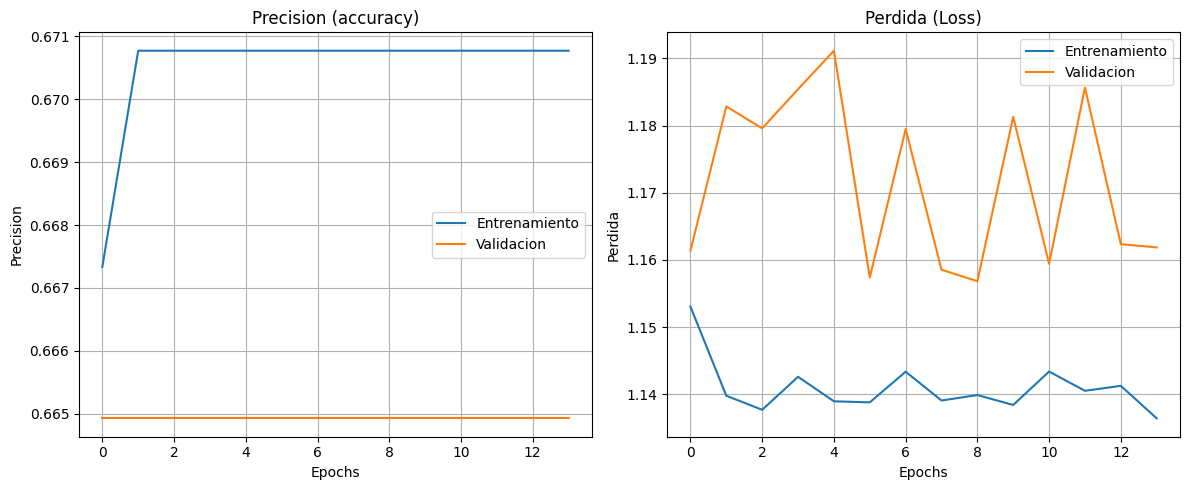

In [56]:
# Visualizamos las curvas

ruta_historial = '/content/drive/MyDrive/Colab Notebooks/Dataset/historia_modelo_imagenes.json'
with open(ruta_historial, 'r') as f:
  historia_imagenes = json.load(f)

print("Historial cargado correctamente")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(historia_imagenes['accuracy'], label='Entrenamiento')
plt.plot(historia_imagenes['val_accuracy'], label='Validacion')
plt.title('Precision (accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(historia_imagenes['loss'], label='Entrenamiento')
plt.plot(historia_imagenes['val_loss'], label='Validacion')
plt.title('Perdida (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Perdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

La grafica nos tramite un mensaje bastante claro. No esta habiendo aprendizaje, o al menos no mas alla del primer epoch. La precision sigue una linea totalmente plana despues, y la perdida muestra muchos altibajos.

Por coherencia vamos tambien a evaluar como el modelo genera predicciones, pero tenemos bastante claro que tenemos que mejorarlo.

In [57]:
import numpy as np

# Obtenemos las predicciones
y_pred_probs = modelo.predict(test_gen)

# Convertimos las probabilidades
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step


<Figure size 700x600 with 0 Axes>

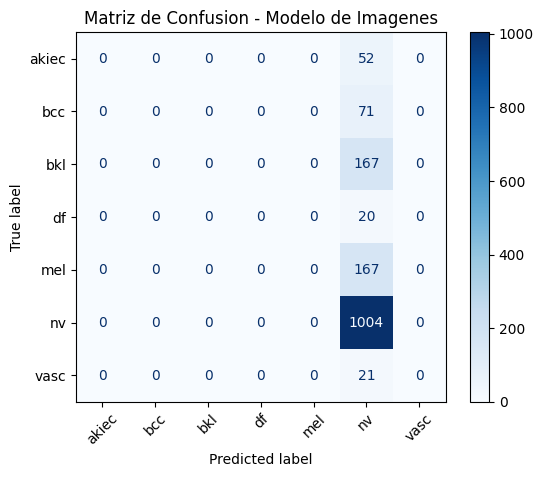

In [58]:
clases = list(test_gen.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
plt.figure(figsize=(7, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusion - Modelo de Imagenes")
plt.grid(False)
plt.show()

In [60]:
clases = list(test_gen.class_indices.keys())
print("Informe de clasificacion – Modelo de imágenes:\n")
print(classification_report(y_true, y_pred, target_names=clases))

Informe de clasificacion – Modelo de imágenes:

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        52
         bcc       0.00      0.00      0.00        71
         bkl       0.00      0.00      0.00       167
          df       0.00      0.00      0.00        20
         mel       0.00      0.00      0.00       167
          nv       0.67      1.00      0.80      1004
        vasc       0.00      0.00      0.00        21

    accuracy                           0.67      1502
   macro avg       0.10      0.14      0.11      1502
weighted avg       0.45      0.67      0.54      1502



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Y efectivamente, como hemos visto anteriormente, el modelo no es demasiado bueno haciendo otra cosa que no sea detectar la categoria con mas instancias en nuestro dataset, 'nv'. Asi que como ya veniamos anunciando, vamos a mejorar nuestro modelo.

In [61]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

num_clases = len(train_gen.class_indices)
input_shape = (224, 224, 3)

base_model =EfficientNetB0(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Modelo mejorado
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(num_clases, activation='softmax')(x)

modelo = Model(inputs, outputs)

modelo.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [62]:
modelo.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,222,250 (16.11 MB)

 Trainable params: 172,679 (674.53 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Dado el prometedor resultado que nos ha dado en el Hito 1, vamos tambien a modificar los pesos de las clases.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

clases = np.unique(train_df['dx'])

pesos = compute_class_weight(class_weight='balanced', classes=clases, y=train_df['dx'])
pesos_clase = dict(zip(clases, pesos))

pesos_clase_idx = {train_gen.class_indices[cls]: peso for cls, peso in pesos_clase.items()}

print("Pesos por clase:", pesos_clase_idx)

Pesos por clase: {0: np.float64(4.491634491634492), 1: np.float64(2.762168579343095), 2: np.float64(1.2916358253145819), 3: np.float64(14.044265593561368), 4: np.float64(1.2899648863426354), 5: np.float64(0.2129736986635748), 6: np.float64(10.072150072150071)}


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Ruta para guardar modelo e historial
ruta_modelo_img_v2 = '/content/drive/MyDrive/Colab Notebooks/Dataset/modelo_imagenes_v2.keras'
ruta_historial_img_v2 = '/content/drive/MyDrive/Colab Notebooks/Dataset/historial_modelo_imagenes_v2.json'

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    filepath=ruta_modelo_img_v2,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Entrenamiento
historia_v2 = modelo.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, checkpoint],
    class_weight=pesos_clase_idx
)

# Guardamos modelo e historial
modelo.save(ruta_modelo_img_v2)
print("Modelo guardado en:", ruta_modelo_img_v2)

with open(ruta_historial_img_v2, 'w') as f:
    json.dump(historia_v2.history, f)
print("Historial guardado en:", ruta_historial_img_v2)

Epoch 1/30


KeyboardInterrupt: 

Historial cargado correctamente


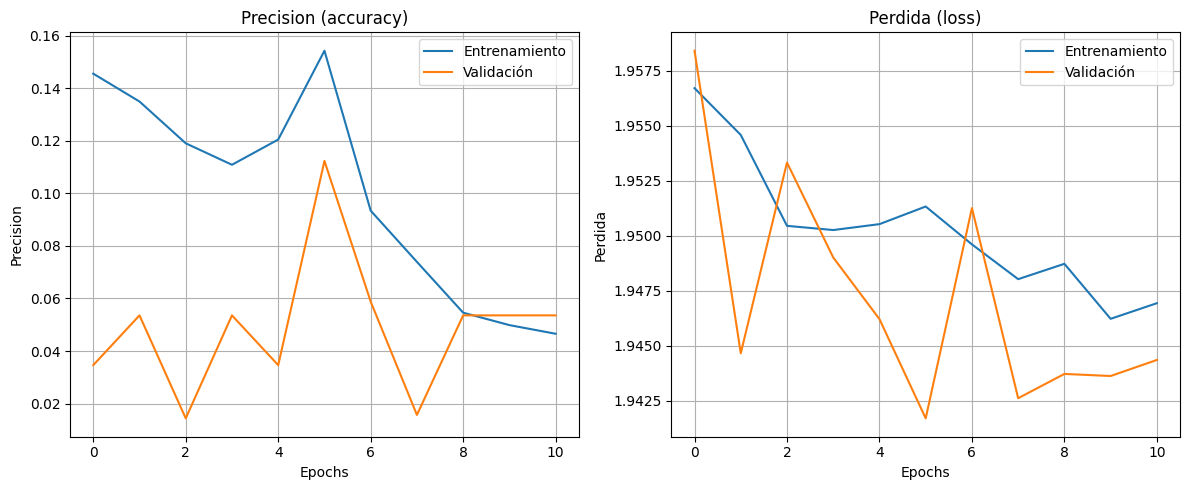

In [ ]:
# Cargamos el historial
ruta_historial_img_v2 = '/content/drive/MyDrive/Colab Notebooks/Dataset/historial_modelo_imagenes_v2.json'
with open(ruta_historial_img_v2, 'r') as f:
  historial_v2 = json.load(f)

print("Historial cargado correctamente")

# Curvas de precisión y pérdida
plt.figure(figsize=(12, 5))

# Precision
plt.subplot(1, 2, 1)
plt.plot(historial_v2['accuracy'], label='Entrenamiento')
plt.plot(historial_v2['val_accuracy'], label='Validación')
plt.title('Precision (accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Perdida
plt.subplot(1, 2, 2)
plt.plot(historial_v2['loss'], label='Entrenamiento')
plt.plot(historial_v2['val_loss'], label='Validación')
plt.title('Perdida (loss)')
plt.xlabel('Epochs')
plt.ylabel('Perdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Modelo cargado desde: /content/drive/MyDrive/Colab Notebooks/Dataset/modelo_imagenes_v2.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 435ms/step


<Figure size 700x600 with 0 Axes>

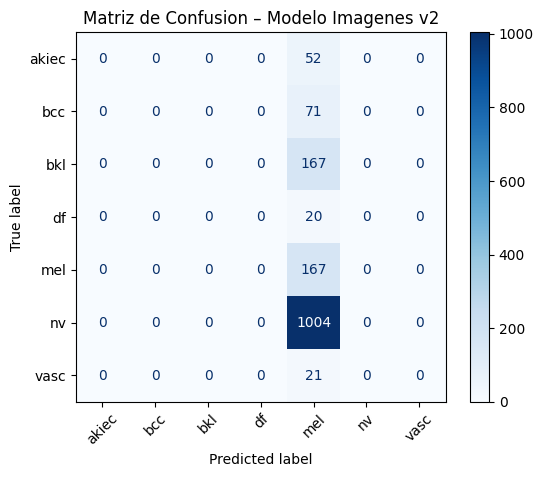

Informe de clasificacion – Modelo Imagenes v2:

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        52
         bcc       0.00      0.00      0.00        71
         bkl       0.00      0.00      0.00       167
          df       0.00      0.00      0.00        20
         mel       0.11      1.00      0.20       167
          nv       0.00      0.00      0.00      1004
        vasc       0.00      0.00      0.00        21

    accuracy                           0.11      1502
   macro avg       0.02      0.14      0.03      1502
weighted avg       0.01      0.11      0.02      1502



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Cargamos el modelo
ruta_modelo_img_v2 = '/content/drive/MyDrive/Colab Notebooks/Dataset/modelo_imagenes_v2.keras'
modelo = load_model(ruta_modelo_img_v2)
print("Modelo cargado desde:", ruta_modelo_img_v2)

# Predicciones
y_pred_probs = modelo.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes

# Nombres de las clases
clases = list(test_gen.class_indices.keys())

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)

plt.figure(figsize=(7, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusion – Modelo Imagenes v2")
plt.grid(False)
plt.show()

# Informe de clasificación
print("Informe de clasificacion – Modelo Imagenes v2:\n")
print(classification_report(y_true, y_pred, target_names=clases))


De nuevo, los resultados hablan por si solos, y lo que nos estan diciendo es que este ultimo cambio no ha obtenido la mejora que esperabamos. Aunque pueda parecer desafortunado, esto es informativo, y nos ayuda a decidir el siguiente paso.

En este caso, vamos a aplicar un fine tuning mas completo, y vamos a descongelar la red convolucional. Tambien vamos incluir mas capas de dropout y batchnormalization en nuestra red, y vamos a quitar la modificacion de los pesos, por que no ha dado el resultado que esperabamos.

In [63]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Ruta de guardado
ruta_modelo_finetune_full = '/content/drive/MyDrive/Colab Notebooks/Dataset/modelo_imagenes_finetune_full.keras'
ruta_historial_finetune_full = '/content/drive/MyDrive/Colab Notebooks/Dataset/historial_modelo_imagenes_finetune_full.json'

# Establecemos la base
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

# Construimos el modelo
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)

modelo = Model(inputs, outputs)

modelo.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [64]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    filepath=ruta_modelo_finetune_full,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

historia_finetune_full = modelo.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

# Guardado
modelo.save(ruta_modelo_finetune_full)
print("Modelo guardado en:", ruta_modelo_finetune_full)

with open(ruta_historial_finetune_full, 'w') as f:
    json.dump(historia_finetune_full.history, f)
print("Historial guardado en:", ruta_historial_finetune_full)

Epoch 1/30


KeyboardInterrupt: 

Historial cargado correctamente


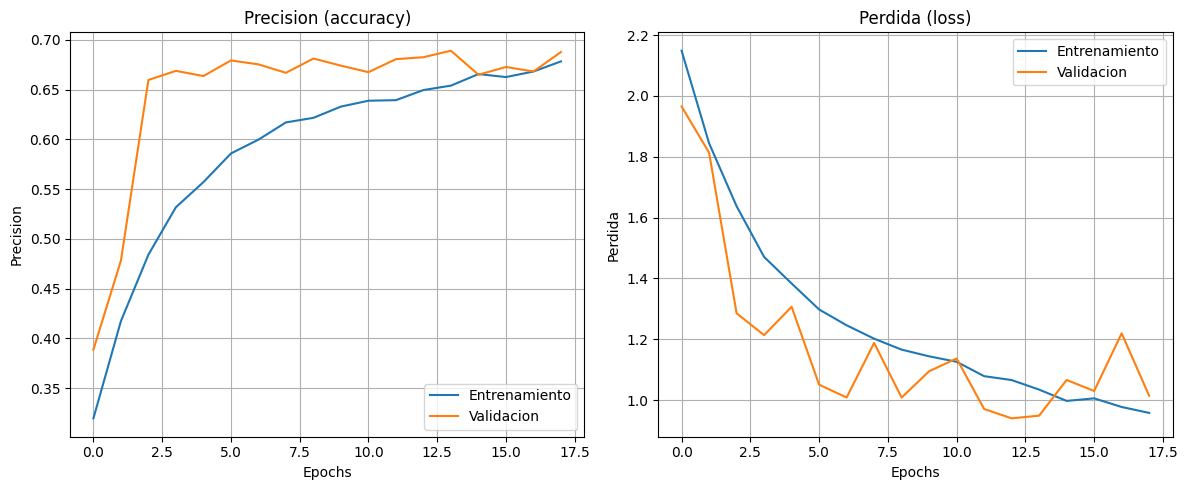

In [65]:
# Cargado
ruta_historial_finetune_full = '/content/drive/MyDrive/Colab Notebooks/Dataset/historial_modelo_imagenes_finetune_full.json'
with open(ruta_historial_finetune_full, 'r') as f:
  historial_finetune_full = json.load(f)

print("Historial cargado correctamente")

# Visualizacion
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(historial_finetune_full['accuracy'], label='Entrenamiento')
plt.plot(historial_finetune_full['val_accuracy'], label='Validacion')
plt.title('Precision (accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(historial_finetune_full['loss'], label='Entrenamiento')
plt.plot(historial_finetune_full['val_loss'], label='Validacion')
plt.title('Perdida (loss)')
plt.xlabel('Epochs')
plt.ylabel('Perdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Ahora si que podemos apreciar como el modelo ha aprendido de manera regular en cada epoch, hasta llegar a un momento en el que el progreso se ha estabilizado y EarlyStopping ha detenido el aprendizaje.

Comparando estas curvas de aprendizaje con las de los previos intentos vemos que este modelo funciona mucho mejor. O al menos, tiene la capacidad de aprender, cosa que no podiamos decir antes.

Pero de nuevo, para comprobar si este aprendizaje se esta reflejando en realidad en capacidad de prediccion, vamos a evaluarlo como hemos hecho antes.

Modelo ya cargado
47/47 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step


<Figure size 700x600 with 0 Axes>

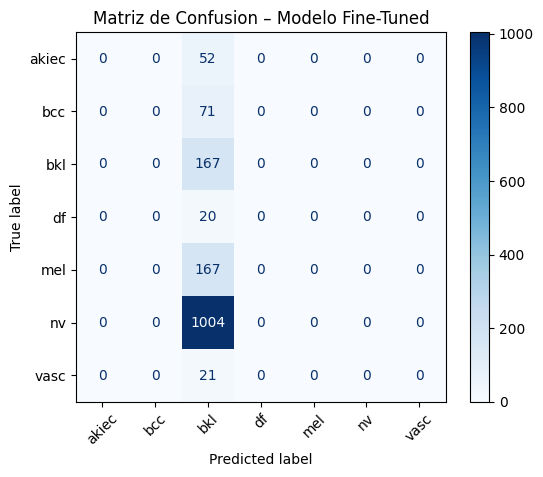

Informe de clasificacion – Modelo Fine-Tuned:

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        52
         bcc       0.00      0.00      0.00        71
         bkl       0.11      1.00      0.20       167
          df       0.00      0.00      0.00        20
         mel       0.00      0.00      0.00       167
          nv       0.00      0.00      0.00      1004
        vasc       0.00      0.00      0.00        21

    accuracy                           0.11      1502
   macro avg       0.02      0.14      0.03      1502
weighted avg       0.01      0.11      0.02      1502



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [66]:
ruta_historial_finetune_full = '/content/Drive/MyDrive/Colab Notebooks/Dataset/historial_modelo_imagenes_finetune_full.json'

# Cargamos de el historial si el modelo no esta en la memoria
try:
  modelo
  print("Modelo ya cargado")
except NameError:
  modelo = load_model(ruta_modelo_finetune_full)
  print("Modelo cargado desde:", ruta_modelo_finetune_full)

# Predicciones
Y_pred_probs = modelo.predict(test_gen)
y_pred = np.argmax(Y_pred_probs, axis=1)
y_true = test_gen.classes

# Clases
clases = list(test_gen.class_indices.keys())

# Matriz de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)

plt.figure(figsize=(7, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusion – Modelo Fine-Tuned")
plt.grid(False)
plt.show()

# Informe de clasificacion
print("Informe de clasificacion – Modelo Fine-Tuned:\n")
print(classification_report(y_true, y_pred, target_names=clases))

Los resultados nos indican que aunque el modelo ha aprendido y es mejor que el modelo tabular en general, sigue sin tener una precision demasiado satisfactoria en otra clase que no sea 'nv'. Con mas tiempo, probablemente podriamos mejorar estos resultados modificando hiperparametros, trabajando mas con el fine-tuning, y jugando con las capas de nuestra red convolucional.

Pero para cumplir con las instrucciones del Hito 2, creemos que esto seria suficiente, asi que pasamos a continuar con los siguientes hitos.

# Hito 3

En este hito debemos usar una estrategia late-fusion, en la que combinaremos las predicciones realizadas por nuestros dos modelos anteriores: el tabular y el de imagenes.


In [67]:
from tensorflow.keras.models import load_model

# Ruta de los modelos
ruta_tabular = '/content/drive/MyDrive/Colab Notebooks/Dataset/modelo_tabular_pesos.keras'
ruta_imagenes = '/content/drive/MyDrive/Colab Notebooks/Dataset/modelo_imagenes_finetune_full.keras'

# Modelo tabular
try:
  modelo_tabular
  print("Modelo tabular ya cargado")
except NameError:
  modelo_tabular = load_model(ruta_tabular)
  print("Modelo tabular cargado desde:", ruta_tabular)

# Modelo imagenes
try:
  modelo_imagenes
  print("Modelo imagenes ya cargado")
except NameError:
  modelo_imagenes = load_model(ruta_imagenes)
  print("Modelo imagenes cargado desde:", ruta_imagenes)

Modelo tabular cargado desde: /content/drive/MyDrive/Colab Notebooks/Dataset/modelo_tabular_pesos.keras
Modelo imagenes cargado desde: /content/drive/MyDrive/Colab Notebooks/Dataset/modelo_imagenes_finetune_full.keras


A la hora de concatenar los datos nos ha surgido un problema por haber eliminado las imagenes ilegibles. Al ser los datos entre modelo tabular y modelo de imagenes distintos, el codigo devuelve un error. Asi que vamos a eliminar tambien los datos asociados a las imagenes ilegibles en el modelo tabular.

In [68]:
ilegibles_train = train_df[~train_df['filepath'].apply(es_legible)]['image_id'].tolist()
ilegibles_val = val_df[~val_df['filepath'].apply(es_legible)]['image_id'].tolist()
ilegibles_test = test_df[~test_df['filepath'].apply(es_legible)]['image_id'].tolist()

In [69]:
train_df = train_df[~train_df['image_id'].isin(ilegibles_train)].copy()
val_df = val_df[~val_df['image_id'].isin(ilegibles_val)].copy()
test_df = test_df[~test_df['image_id'].isin(ilegibles_test)].copy()

In [70]:
X_train_tab = train_df[feature_cols].astype('float32').values
X_val_tab = val_df[feature_cols].astype('float32').values
X_test_tab = test_df[feature_cols].astype('float32').values

y_train = train_df['label'].values
y_val = val_df['label'].values
y_test = test_df['label'].values


In [71]:
import numpy as np
# Predicciones del modelo de imagenes
pred_img_train = modelo_imagenes.predict(train_gen)
pred_img_val   = modelo_imagenes.predict(val_gen)
pred_img_test  = modelo_imagenes.predict(test_gen)

219/219 ━━━━━━━━━━━━━━━━━━━━ 138s 600ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 359ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 358ms/step


In [72]:
# Predicciones del modelo tabular
pred_tab_train = modelo_tabular.predict(X_train_tab)
pred_tab_val   = modelo_tabular.predict(X_val_tab)
pred_tab_test  = modelo_tabular.predict(X_test_tab)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [73]:
x_train_fusion = np.concatenate([pred_tab_train, pred_img_train], axis=1)
x_val_fusion = np.concatenate([pred_tab_val, pred_img_val], axis=1)
x_test_fusion = np.concatenate([pred_tab_test, pred_img_test], axis=1)

In [74]:
import os
import json
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import load_model
import numpy as np

# Ruta de guardado
model_latefusion_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/modelo_latefusion.keras'
model_latefusion_history_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/historial_modelo_latefusion.json'

# Cargado
if os.path.exists(model_latefusion_path):
    modelo_latefusion = load_model(model_latefusion_path)
    print("Modelo cargado desde:", model_latefusion_path)

else:
    print("Modelo No Encontrado - Comenzando Entrenamiento")

    num_classes = len(np.unique(y_train))

    # Definimos el modelo
    model_fusion = models.Sequential([
        layers.Input(shape=(x_train_fusion.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compilamos
    model_fusion.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Entrenamos
    history_fusion = model_fusion.fit(
        x_train_fusion, y_train,
        validation_data=(x_val_fusion, y_val),
        epochs=30,
        batch_size=32,
        callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=1
    )

    # Guardamos modelo e historial
    model_fusion.save(model_latefusion_path)
    print("Modelo guardado en:", model_latefusion_path)
    with open(model_latefusion_history_path, 'w') as f:
        json.dump(history_fusion.history, f)
    print("Historial guardado en:", model_latefusion_history_path)

Modelo cargado desde: /content/drive/MyDrive/Colab Notebooks/Dataset/modelo_latefusion.keras


Historial cargado correctamente
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4558 - loss: 1.5177
Test Loss: 0.9574
Test Accuracy: 0.6864


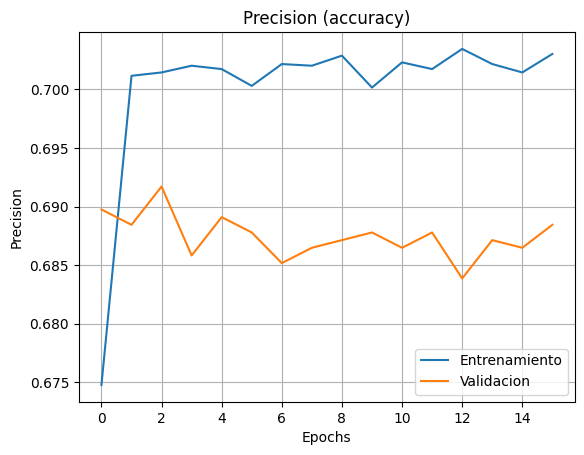

In [77]:
import matplotlib.pyplot as plt

# Cargamos el historial
with open(model_latefusion_history_path, 'r') as f:
    history_fusion = json.load(f)

print("Historial cargado correctamente")

test_loss, test_accuracy = modelo_latefusion.evaluate(x_test_fusion, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Visualizamos las curvas de aprendizaje
plt.plot(history_fusion['accuracy'], label='Entrenamiento')
plt.plot(history_fusion['val_accuracy'], label='Validacion')
plt.title('Precision (accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


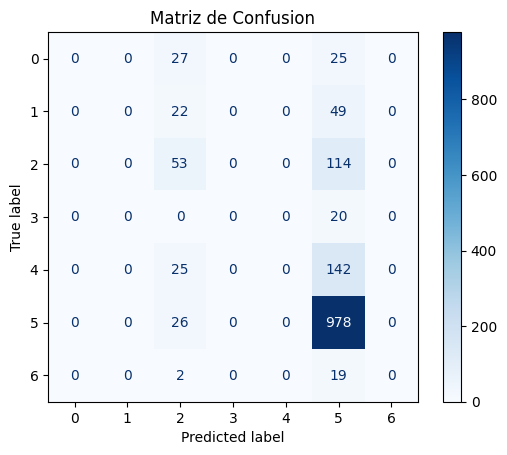

Informe de Clasificacion:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.00      0.00      0.00        71
           2       0.34      0.32      0.33       167
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00       167
           5       0.73      0.97      0.83      1004
           6       0.00      0.00      0.00        21

    accuracy                           0.69      1502
   macro avg       0.15      0.18      0.17      1502
weighted avg       0.52      0.69      0.59      1502



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [79]:
# Matriz de confusion
y_pred = modelo_latefusion.predict(x_test_fusion)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusion")
plt.show()

# Informe de clasificacion
print("Informe de Clasificacion:")
print(classification_report(y_test, y_pred_labels))

In [81]:
from sklearn.metrics import accuracy_score

# Modelo tabular por sí solo
y_pred_tab = np.argmax(pred_tab_test, axis=1)
acc_tab = accuracy_score(y_test, y_pred_tab)
print(f"Accuracy modelo tabular: {acc_tab:.4f}")

# Modelo de imagen por sí solo
y_pred_img = np.argmax(pred_img_test, axis=1)
acc_img = accuracy_score(y_test, y_pred_img)
print(f"Accuracy modelo de imagenes: {acc_img:.4f}")

# Modelo fusionado
y_pred_fusion = np.argmax(modelo_latefusion.predict(x_test_fusion), axis=1)
acc_fusion = accuracy_score(y_test, y_pred_fusion)
print(f"Accuracy modelo de fusion: {acc_fusion:.4f}")


Accuracy modelo tabular: 0.3822
Accuracy modelo de imagenes: 0.6858
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy modelo de fusion: 0.6864


Volvemos al resultado que ya hemos observado anteriormente. La categoria 'nv', es la unica donde nuestro modelo rinde satisfactoriamente.

Son resultados tan similares que casi nos hacen sospechar que no hemos fusionado con exito las predicciones, pero al comparar las puntuaciones de precision de cada modelo por separado, vemos que son diferentes, lo que nos hace entender que si que se han fusionado, e influido por tanto a este modelo latefusion, pero este efecto no es estrictamente positivo.

Vamos a ver si el siguiente hito puede ayudarnos a mejorar nuestro modelo.

# Hito 4

En este ultimo hito vamos a extraer los embeddings de los modelos anteriores, concatenarlos, y entrenar un nuevo clasificador sobre esta combinacion. Las expectativas serian que mejorase el rendimiento de los modelos anteriores de manera individual, pero como ya hemos visto en la estrategia latefusion, quizas esto requeriria mucho mas finetuning para que asi fuese.

Vamos a empezar por extraer los embeddings.

In [100]:
from tensorflow.keras.models import load_model

# Ruta de los modelos
ruta_tabular = '/content/drive/MyDrive/Colab Notebooks/Dataset/modelo_tabular_pesos.keras'
ruta_imagenes = '/content/drive/MyDrive/Colab Notebooks/Dataset/modelo_imagenes_finetune_full.keras'

# Modelo tabular
try:
  modelo_tabular_pesos
  print("Modelo tabular ya cargado")
except NameError:
  modelo_tabular_pesos = load_model(ruta_tabular)
  print("Modelo tabular cargado desde:", ruta_tabular)

# Modelo imagenes
try:
  modelo_imagenes_finetune_full
  print("Modelo imagenes ya cargado")
except NameError:
  modelo_imagenes_finetune_full = load_model(ruta_imagenes)
  print("Modelo imagenes cargado desde:", ruta_imagenes)

Modelo tabular ya cargado
Modelo imagenes cargado desde: /content/drive/MyDrive/Colab Notebooks/Dataset/modelo_imagenes_finetune_full.keras


In [121]:
# Llamamos a los modelos para inicializarlos completamente
_ = modelo_tabular_pesos.predict(X_train_tab[:1])
_ = modelo_imagenes_finetune_full.predict(train_gen, steps=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


In [113]:
modelo_tabular_pesos.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,815 (132.09 KB)

 Trainable params: 11,271 (44.03 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,544 (88.07 KB)

In [119]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Definimos el input shape
input_shape = modelo_tabular_pesos.input_shape[1:]
tabular_input = Input(shape=input_shape, name='tabular_input')
x = tabular_input
for layer in modelo_tabular_pesos.layers[:-1]:
    x = layer(x)

# Creamos el modelo funcional truncado
modelo_tabular_embedding = Model(inputs=tabular_input, outputs=x, name='modelo_tabular_embedding')

Ahora ya tenemos nuestro modelo tabular truncado, vamos a generar el del modelo de imagenes.

In [120]:
for i, layer in enumerate(modelo_imagenes_finetune_full.layers):
    print(i, layer.name, layer.__class__.__name__)

0 input_layer_7 InputLayer
1 efficientnetb0 Functional
2 global_average_pooling2d_2 GlobalAveragePooling2D
3 batch_normalization BatchNormalization
4 dense_10 Dense
5 dropout_5 Dropout
6 dense_11 Dense
7 dropout_6 Dropout
8 dense_12 Dense


In [122]:
from tensorflow.keras.models import Model

modelo_imagenes_embedding = Model(
    inputs=modelo_imagenes_finetune_full.input,
    outputs=modelo_imagenes_finetune_full.get_layer("global_average_pooling2d_2").output,
    name="modelo_imagenes_embedding"
)

In [123]:
modelo_imagenes_embedding.summary()

Model: "modelo_imagenes_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

Y ya tenemos el de nuestro modelo de imagenes. El siguiente paso es extraer sus embeddings y fusionarlos.

In [125]:
import numpy as np

# 1️Obtenemos los embeddings TABULARES
X_train_tab_embed = modelo_tabular_embedding.predict(X_train_tab, verbose=1)
X_val_tab_embed   = modelo_tabular_embedding.predict(X_val_tab, verbose=1)
X_test_tab_embed  = modelo_tabular_embedding.predict(X_test_tab, verbose=1)

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [126]:
# Obtenemos los embeddings de IMÁGENES
X_train_img_embed = modelo_imagenes_embedding.predict(train_gen, verbose=1)
X_val_img_embed   = modelo_imagenes_embedding.predict(val_gen, verbose=1)
X_test_img_embed  = modelo_imagenes_embedding.predict(test_gen, verbose=1)

219/219 ━━━━━━━━━━━━━━━━━━━━ 132s 604ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 342ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 344ms/step


In [127]:
# Fusionamos los embeddings
X_train_fusion = np.concatenate([X_train_tab_embed, X_train_img_embed], axis=1)
X_val_fusion   = np.concatenate([X_val_tab_embed, X_val_img_embed], axis=1)
X_test_fusion  = np.concatenate([X_test_tab_embed, X_test_img_embed], axis=1)

In [128]:
print("Forma final del vector de entrada fusionado (train):", X_train_fusion.shape)

Forma final del vector de entrada fusionado (train): (6980, 1344)


In [132]:
import os
import json
from tensorflow.keras import layers, models, callbacks

# Rutas de guardado
ruta_modelo_earlyfusion = '/content/drive/MyDrive/Colab Notebooks/Dataset/modelo_earlyfusion.keras'
ruta_historial_earlyfusion = '/content/drive/MyDrive/Colab Notebooks/Dataset/historial_modelo_earlyfusion.json'

# Numero de clases
num_classes = len(np.unique(y_train))

# Definimos el modelo
modelo_earlyfusion = models.Sequential([
    layers.Input(shape=(X_train_fusion.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])
# Compilamos
modelo_earlyfusion.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenamos
history_early = modelo_earlyfusion.fit(
    X_train_fusion, y_train,
    validation_data=(X_val_fusion, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# Guardamos modelo e historial
modelo_earlyfusion.save(ruta_modelo_earlyfusion)
print("Modelo guardado en:", ruta_modelo_earlyfusion)

with open(ruta_historial_earlyfusion, 'w') as f:
    json.dump(history_early.history, f)
print("Historial guardado en:", ruta_historial_earlyfusion)

Epoch 1/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6618 - loss: 1.1447 - val_accuracy: 0.6858 - val_loss: 1.0143
Epoch 2/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7043 - loss: 0.9347 - val_accuracy: 0.6871 - val_loss: 1.0263
Epoch 3/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7032 - loss: 0.9176 - val_accuracy: 0.6878 - val_loss: 1.0144
Epoch 4/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7095 - loss: 0.8746 - val_accuracy: 0.6924 - val_loss: 1.0326
Epoch 5/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7298 - loss: 0.8035 - val_accuracy: 0.6826 - val_loss: 1.0679
Epoch 6/30
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7298 - loss: 0.7945 - val_accuracy: 0.6858 - val_loss: 1.1330
Modelo guardado en: /content/drive/MyDrive/Colab Notebooks/Dataset/modelo_earlyfusion.keras
Historial guardado en: /content/drive/MyDrive/Colab Notebooks/Dataset/historial_modelo_earlyfusion.json


Usando historial de esta sesion...
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4604 - loss: 1.5435
Test Accuracy: 0.6911
Test Loss: 1.0204


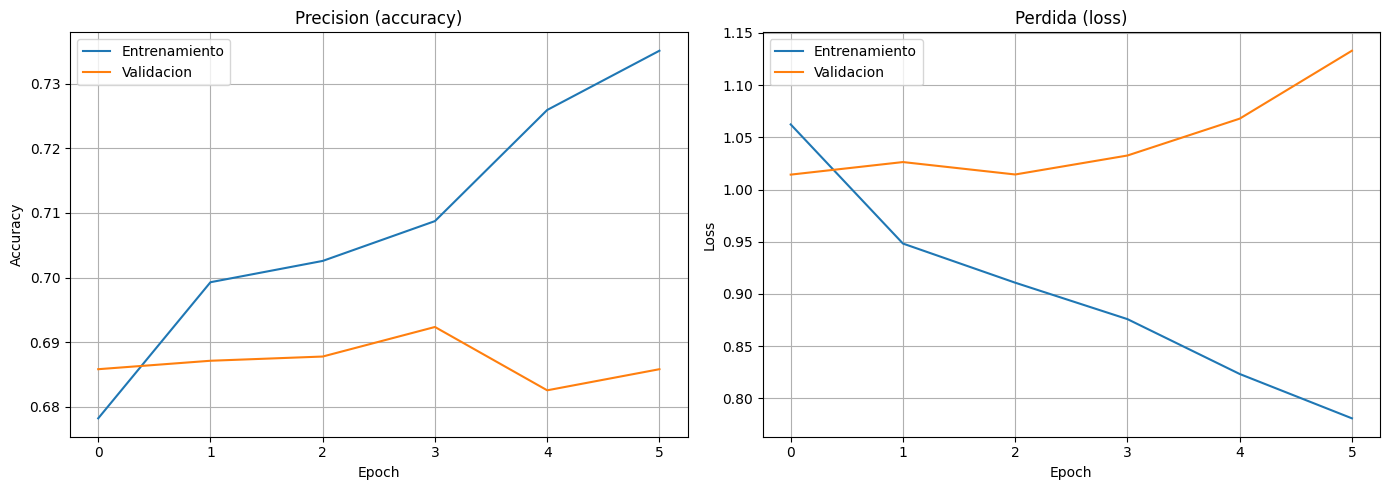

In [133]:
import json
import matplotlib.pyplot as plt

# Ruta al historial
ruta_historial_earlyfusion = '/content/drive/MyDrive/Colab Notebooks/Dataset/historial_modelo_earlyfusion.json'

# Si history_early no está en memoria, lo cargamos
try:
    history_early
    print("Usando historial de esta sesion...")
    history_data = history_early.history
except NameError:
    print("Cargando historial...")
    with open(ruta_historial_earlyfusion, 'r') as f:
        history_data = json.load(f)

# Evaluamos en el set de test
test_loss, test_accuracy = modelo_earlyfusion.evaluate(X_test_fusion, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Graficamos curvas de entrenamiento
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_data['accuracy'], label='Entrenamiento')
plt.plot(history_data['val_accuracy'], label='Validacion')
plt.title('Precision (accuracy)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_data['loss'], label='Entrenamiento')
plt.plot(history_data['val_loss'], label='Validacion')
plt.title('Perdida (loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Estas curvas de aprendizaje y perdida parecen indicarnos que existe un leve overfitting. En precision, la curva de entrenamiento sube de manera regular, pero la de validacion subre hasta un punto y luego se estanca y baja. En perdida vemos una historia similar pero invertida. En entrenamiento baja de manera regular, mientras que en validacion se mantiene e incluso sube.

Lo que esto nos quiere decir es que el modelo de earlyfusion aprende, pero empieza a sobreajustar pronto. Por suerte, al haber implementado early stopping, el entrenamiento se paro antes de que el overfitting fuera mas pronunciado.

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


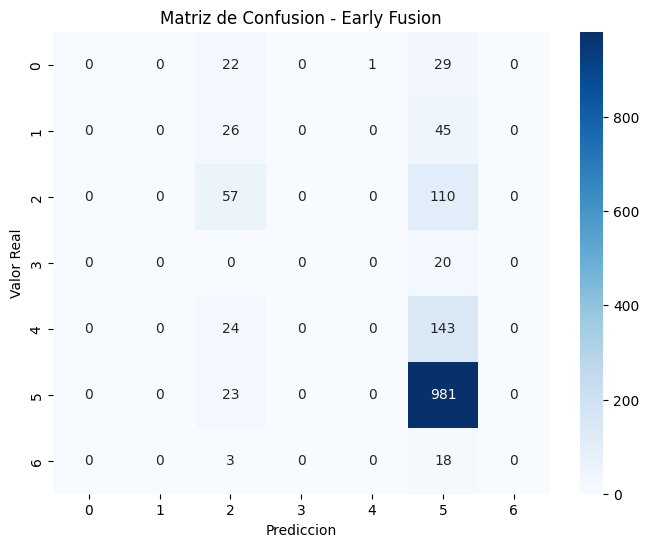

Informe de Clasificacion:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.00      0.00      0.00        71
           2       0.37      0.34      0.35       167
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00       167
           5       0.73      0.98      0.83      1004
           6       0.00      0.00      0.00        21

    accuracy                           0.69      1502
   macro avg       0.16      0.19      0.17      1502
weighted avg       0.53      0.69      0.60      1502



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [134]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtenemos predicciones del modelo en el test set
y_pred_proba = modelo_earlyfusion.predict(X_test_fusion)
y_pred = np.argmax(y_pred_proba, axis=1)

# Generamos la matriz de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizacion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusion - Early Fusion")
plt.xlabel("Prediccion")
plt.ylabel("Valor Real")
plt.show()

# Informe de clasificación
print("Informe de Clasificacion:\n")
print(classification_report(y_test, y_pred))


# 5 Presentacion de Resultados

Hemos entrenado y evaluado cuatro modelos distintos. En el hito 3 ya mostramos una comparativa entre los modelos tabular, de imagenes y latefusion. En este ultimo paso procedemos a hacer una comparativa un poco mas en detalle del modelo earlyfusion con las dos primeras.

In [135]:
from sklearn.metrics import classification_report

# Definimos una funcion para evaluar nuestros modelos
def evaluar_modelo(nombre, modalidad, y_true, y_pred):
    reporte = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    return {
        "Modelo": nombre,
        "Modalidad": modalidad,
        "Accuracy": reporte["accuracy"],
        "F1 Macro": reporte["macro avg"]["f1-score"],
        "F1 Weighted": reporte["weighted avg"]["f1-score"]
    }

In [138]:
# Tabular
y_pred_tab = modelo_tabular_pesos.predict(X_test_tab)
y_pred_tab = np.argmax(y_pred_tab, axis=1)

# Imágenes
y_pred_img = modelo_imagenes_finetune_full.predict(test_gen)
y_pred_img = np.argmax(y_pred_img, axis=1)

# Early fusion
y_pred_early = modelo_earlyfusion.predict(X_test_fusion)
y_pred_early = np.argmax(y_pred_early, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 276ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [139]:
resultados = []

resultados.append(evaluar_modelo("Tabular", "Solo tabular", y_test, y_pred_tab))
resultados.append(evaluar_modelo("Imágenes", "Solo imagen", y_test, y_pred_img))
resultados.append(evaluar_modelo("Early Fusion", "Fusión temprana", y_test, y_pred_early))

df_resultados = pd.DataFrame(resultados).sort_values("Accuracy", ascending=False).reset_index(drop=True)
df_resultados

,Modelo,Modalidad,Accuracy,F1 Macro,F1 Weighted
0,Early Fusion,Fusión temprana,0.691079,0.169847,0.597442
1,Imágenes,Solo imagen,0.685752,0.189491,0.595814
2,Tabular,Solo tabular,0.382157,0.187260,0.453392


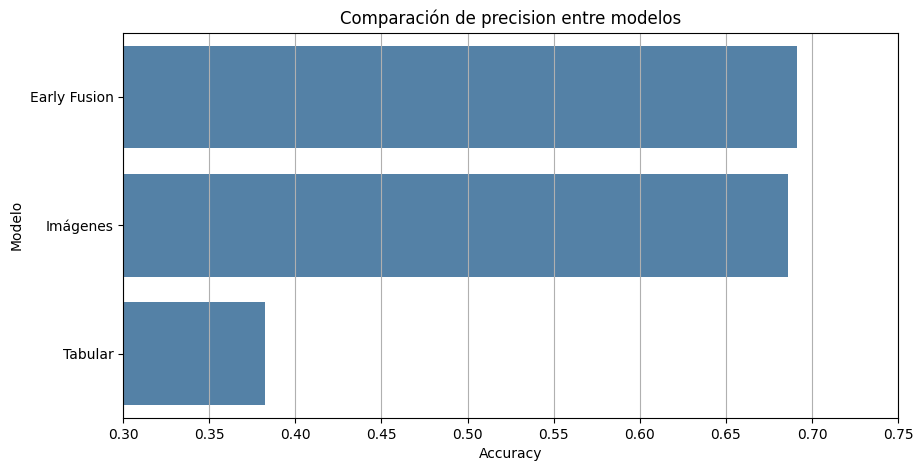

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=df_resultados, x="Accuracy", y="Modelo", color="steelblue")
plt.title("Comparación de precision entre modelos")
plt.xlabel("Accuracy")
plt.xlim(0.3, 0.75)
plt.grid(axis='x')
plt.show()

In [148]:
# Exportar resultados comparativos
df_resultados.to_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/resultados_modelos_fusion.csv', index=False)
print("Resultados guardados")

Resultados guardados


Como vemos, el modelo earlyfusion ha conseguido una mejora sobre los modelos tabular y de imagenes, con una precision de un 69%. Son resultados positivos, y demuestran que la combinacion entre modelos tabular y de imagenes ha resultado en una mejoria del modelo fusionado.

Sin embargo, cuando observamos el rendimiento predictivo del modelo a traves de la matriz de confusion y el informe de clasificacion, podemos observar que como previamente habiamos visto, el modelo es bastante bueno en detectar correctamente instancias pertenecientes a la clase 'nv', pero no demasiado en el resto de variables.

# 6 Discusion de Resultados

Lo que estos ultimos resultados nos demuestran es que los distintos tipos de redes neuronales utilizados, como la red neuronal totalmente conectada (Fully Connected Neural Network, o Multilayer Perceptron - MLP) que hemos empleado con nuestros datos tabulares, o la red convolucional profunda (Convolutional Neural Network) que usamos para las imagenes del dataset, tienen un ambito de uso especifico, y que dependiendo de como las utilicemos, podemos encontrarnos con resultados totalmente distintos.

Por ejemplo, cuando hemos usado la red neuronal MLP en nuestro modelo tabular, hemos obtenido un resultado aparentemente bueno solo atendiendo a datos tabulares. Pero cuando hemos observado en mas detalle esos resultados, hemos visto que no eran tan buenos. El dataset estaba muy desbalanceado, con una clase sobrerrepresentada sobre el resto. Para paliar esto hemos modificado nuestra red neuronal, e incrementado los pesos de las clases de manera proporcional. Esto ha mejorado la capacidad predictiva del modelo con respecto a otras clases, pero en general una precision menor.

Para la red convolucional hemos decidido usar la red ya entrenada EfficientNetB0, que no se encontraba entre las presentadas por el profesor en las clases, pero que hemos encontrado online. Hasta donde hemos podido leer y comparar con otras, debe de haber sido una buena opcion, pero no sabemos si otras habrian sido mejores. Obviamente, de tener mas tiempo si que podriamos haber comparado sin problemas esta red con otras como Resnet. Pero dadas las limitaciones de GPU y tiempo, no nos ha sido posible. Aun asi, el modelo de imagenes tambien ha demostrado ser muy bueno detectando la clase sobrerrepresentada, y lo que es mejor, ha respondido positivamente al fine tuning.

Al fusionar estas redes hemos obtenido resultados dispares. Cuando lo hemos hecho a traves de una estrategia late fusion, no hemos obtenido ninguna mejoria. Y de hecho, el resultado parecia ser peor que el obtenido usando unicamente el modelo de imagenes. Esto quiere decir que quizas el modelo tabular introducia ruido, y que las predicciones de ambos fusionadas no nos estaban reportando un mejor rendimiento.

Sin embargo, al emplear la estrategia early fusion, si que ha habido una mejora del rendimiento. Extrayendo los embeddings de las diferentes redes y aplicandolos a nuestro modelo ha resultado en una leve mejoria en la precision, lo que en este caso indica que con una estrategia adecuada, si que podemos beneficiarnos de la informacion tabular.

Un aspecto frustrante de esta practica ha sido tener que entrenar y reentrenar los modelos cuando cerrabamos la sesion de Colab. Es por eso que decidimos incluir codigo guardando tanto modelo como historial. En algunas ocasiones, incluso utilizando GPU, el modelo tardaba entre 20 y 30 minutos en entrenar, lo que hacia incluso mas tedioso darse cuenta de que se habia de repetir el entrenamiento. Conectado a esto traemos otra frustracion, que es la de saber que podriamos mejorar los resultados empleando distintas tecnicas como mejorando el fine tuning, jugando con los hiperparametros, probando distintas redes convolucionales, distintas arquitecturas de redes...

Pero aun asi, cometer todos esos errores, darnos cuenta de lo que se podia haber hecho mejor, o hasta donde podiamos haber llegado con mas tiempo (y GPU quizas) ha sido un ejercicio de aprendizaje muy valioso.